# Scattering Matrix

First, test if the scattering matrix calculation works without calculatng the viewing matrix. In order to do this, we need to load up some cross section data to initialize `Gas`. Then, we need to load some neutral densities, temperature and an ionosphere to create an `Atmosphere`.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np
import scipy.integrate, scipy.interpolate
import pyauric, mcrt

In [11]:
!grep -A 16 "#ifdef.*VICKERS" ../jsv_rt_cython/RT/cross_sec.h

#ifdef  VICKERS
#define SIGAO__832  ( 3.89  Mbarn)
#define SIGAO2_832  (33.80  Mbarn)
#define SIGAN2_832  ( 0.049 Mbarn)
#define FOSC832       0.0459

#define SIGAO__833  ( 3.89  Mbarn)
#define SIGAO2_833  (14.00  Mbarn)
#define SIGAN2_833  ( 0.29  Mbarn)
#define FOSC833       0.0916

#define SIGAO__834  ( 3.90  Mbarn)
#define SIGAO2_834  (10.40  Mbarn)
#define SIGAN2_834  (10.10  Mbarn)
#define FOSC834       0.1371

static char *credits = "Vickers/Link";


In [12]:
mag = 1e-18
f = lambda L: [ x * mag for x in L ]
csO  = f( [  3.89,  3.89,  3.90 ] )
csO2 = f( [ 33.80, 14.00, 10.40 ] )
csN2 = f( [ 0.049,  0.29, 10.10 ] )

amu = 1.660538921e-27 # kg 
mO = 16 * amu
mO2 = 32 * amu
mN2 = 28 * amu

for name, cs, mass in [ ("O", csO, mO ), ("N2", csN2, mN2 ), ("O2", csO2, mO2 ) ]:
    mcrt.Gas( name, 'absorption', [832, 833, 834], cs, mass )

The absorption cross sections are above, but the scattering cross sections are temperature-dependent.

In [13]:
!grep -A 1 "sig0_834.*=" ../jsv_rt_cython/RT/gsrp.c
!grep "#define.*LAM83[234]" ../jsv_rt_cython/RT/cross_sec.h

sig0_834  = LAM834 * sqrt(16.*_AMU_/2.0/Pi/_kb_/TREF) *
            (Pi*_e_*_e_/_Me_/_c_)*FOSC834;
#define LAM834 (834.466e-8 cm)
#define LAM833 (833.329e-8 cm)
#define LAM832 (832.757e-8 cm)


In [14]:
# fake scattering cross sections
wavelengths = [ 832.757e-8, 833.329e-8, 834.466e-8 ]
mO16 = 1.489917e10 # eV / c^2
#e^2 = hbar c alpha
hbarc = 1.97327e-5 # eV cm
alpha = 1.0/127.0
me = 5.109989e5    # eV / c^2
c = 2.998e10       # cm/s
kb = 8.6173e-5      # eV / K
T = 1000           # K

sig0_over_f = lambda x : x * np.sqrt( mO16 * hbarc * alpha / ( 2 * kb * T * c * me ) )

fosc = [ 0.0459, 0.0916, 0.1371 ]

sigma_scatter = [ sig0_over_f(w)*fosc[i] for (i, w) in enumerate(wavelengths) ]

mcrt.Gas( "O+", 'scattering', [832, 833, 834], sigma_scatter, mO )

print [ (name, gas.sigma[0]) for (name, gas) in mcrt.Gas.species.iteritems() ]
print sigma_scatter

[('N2', 4.900000000000001e-20), ('O+', 3.5791261878102976e-13), ('O2', 3.38e-17), ('O', 3.89e-18)]
[3.5791261878102976e-13, 7.1475631674107099e-13, 1.0712532040813149e-12]


In [15]:
auric = pyauric.AURICManager('./inputs')

n_species = [ "[O]", "[O2]", "[N2]" ]

neutrals = auric.retrieve("atmos.dat", n_species + ['Tn (K)'])
temperatures = neutrals['Tn (K)']
absorbers = { k[1:-1]:v for (k,v) in neutrals.iteritems() if '[' in k }
altitudes = neutrals["ALT"]
absorbers.keys()

msis = np.genfromtxt("inputs/msis.txt")
msis_n  = { k:v for (k,v) in zip(['ALT','O','N2','O2','Tn (K)'], [ msis[::-1,i] for i in xrange(6)] )}
Hm=80
Nm=1.5e5
hm=200
chapman = np.vectorize(lambda z: (Nm)*np.exp((1-(z-hm)/Hm-np.exp(-(z-hm)/Hm))/2))
oplus_new = chapman(msis_n['ALT'])

In [16]:
oplus = auric.retrieve("ionos.dat", ['[e-]'])
oplus.keys()
oplus_interp = scipy.interpolate.interp1d(oplus['ALT'][::-1], oplus['[e-]'][::-1],
                                          bounds_error=False, fill_value=1e-10)
ionos_from_auric = oplus_interp(msis_n['ALT'])

In [17]:
# two streams:
angles = np.array([np.sqrt(1/3.), -np.sqrt(1/3.)])
angles = np.arccos(angles)

viewing_angles = np.arange(95,116) * np.pi / 180

In [18]:
# atmosphere = mcrt.Atmosphere( msis_n['ALT'], angles, msis_n['Tn (K)'], msis_n, ionos_from_auric, viewing_angles ) 
atmosphere = mcrt.Atmosphere( altitudes, angles, temperatures, absorbers, oplus['[e-]'], viewing_angles ) 

In [19]:
Mm = atmosphere.multiple_scatter_matrix( 2 )

In [20]:
n = len(atmosphere.transient)
Q = np.fromiter( ( atmosphere.Q( k, l, 2 ) for k in atmosphere.transient for l in atmosphere.transient ), dtype=np.float )
Q = Q.reshape( ( n, n ) )

In [21]:
def sum_down_square(a):
    N = a.shape[0]
    n = int(np.sqrt(N))
    out = np.empty((n,n))
    for j in xrange(a.size):
        ra, ca = j//N, j%N
        ro, co = ra//n, ca//n
        out[ro,co] += a[ra,ca]
    return out
sum_down_square(a)

array([[ 10.,  18.],
       [ 42.,  50.]])

In [22]:
p = atmosphere.N_layers
Q_sum = sum_down_square(Q)
Mm_sum = sum_down_square(Mm)

IndexError: index 14 is out of bounds for axis 1 with size 14

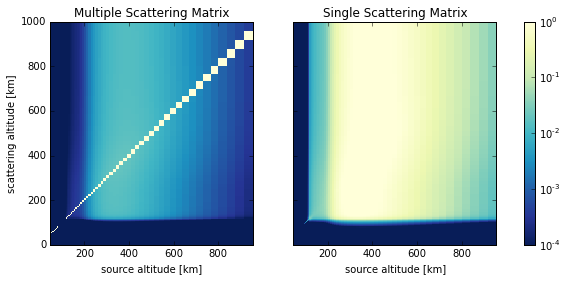

In [71]:
style ={'norm':LogNorm(vmin=1e-4, vmax=1), 
        'cmap':cm.YlGnBu_r
        }

# axlabel = np.hstack([atmosphere.z/1e5]*2)
axlabel=atmosphere.z/1e5

# plt.title('upwelling')
# plt.imshow( Mm[:atmosphere.N_layers,:atmosphere.N_layers], **style )
# plt.colorbar();
# plt.figure()
# plt.title('downwelling')
# plt.imshow( Mm[atmosphere.N_layers:,atmosphere.N_layers:], **style )
# plt.colorbar();

fig, axes = plt.subplots(ncols=2,nrows=1,sharey=True)
fig.set_size_inches((10,4))
#gs = plt.GridSpec(1,3, width_ratios=[10,10,1])
axM, axQ = axes #fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

axM.set_title(r'Multiple Scattering Matrix')
imgM = axM.pcolormesh(axlabel,axlabel, Mm_sum, **style )
axM.set_xlabel('source altitude [km]')
axM.set_ylabel('scattering altitude [km]')
# plt.colorbar(imgM);

imgQ = axQ.pcolormesh(axlabel, axlabel, Q_sum, **style)
axQ.set_title(r'Single Scattering Matrix')
axQ.set_xlabel('source altitude [km]')
# axQ.set_yticklabels([])

# # http://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(axQ)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# cax = plt.subplot(gs[2])
# plt.colorbar(imgM,cax=cax)

# http://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
import matplotlib as mpl
cax,kw = mpl.colorbar.make_axes([ax for ax in axes])
plt.colorbar(imgM,cax=cax,**kw)
axQ.set_aspect(1)
axM.set_aspect(1)

# axQ.set_ylabel('altitude [km]')
# plt.colorbar(imgQ);
plt.savefig('../papers/matrix-technique/figures/graphical-matrices.eps')

In [13]:
thin_lines = ! grep "O.*83[234] A.*initial.*" inputs/dayglo.ver 
thick_lines = ! grep "83[234].*final" inputs/dayglo.ver

In [14]:
feautrier = auric.retrieve( "dayglo.ver", features=thick_lines )
sourcef = auric.retrieve( "dayglo.ver", features=thin_lines )
S = scipy.interpolate.interp1d(sourcef['ALT'][::-1]*1e5, sourcef['O+hv 834 A (initial)'][::-1])
z = sourcef['ALT']
S0 = np.hstack( [ S(atmosphere.z) / 2 ]*2 )
cdf = -scipy.integrate.cumtrapz(sourcef['O+hv 834 A (initial)'], sourcef['ALT'], initial=0) 
cdf = 1 - cdf / np.max(cdf)
dcdf = cdf[1:]-cdf[:-1]
dx = sourcef['ALT'][:-1] - sourcef['ALT'][1:]
pdf = np.zeros_like(cdf)
pdf[1:] = -dcdf/dx
#plt.plot(sourcef['ALT'],cdf, sourcef['ALT'], pdf)

#S0 = np.max(sourcef['O+hv 834 A (initial)'])/np.max(pdf) * pdf
#S0_interp = scipy.interpolate.interp1d(sourcef['ALT'][::-1], S0[::-1], bounds_error=False, fill_value = 0)
#y = S0_interp(atmosphere.z*1e-5)
#S0 = np.hstack( [ y / 2 ] * 2 )
SF = np.dot( S0, Mm )
# print SF
SF = SF.reshape( (2, len(SF)/2) )
# print SF
SF = np.sum(SF, axis=0)
# print SF

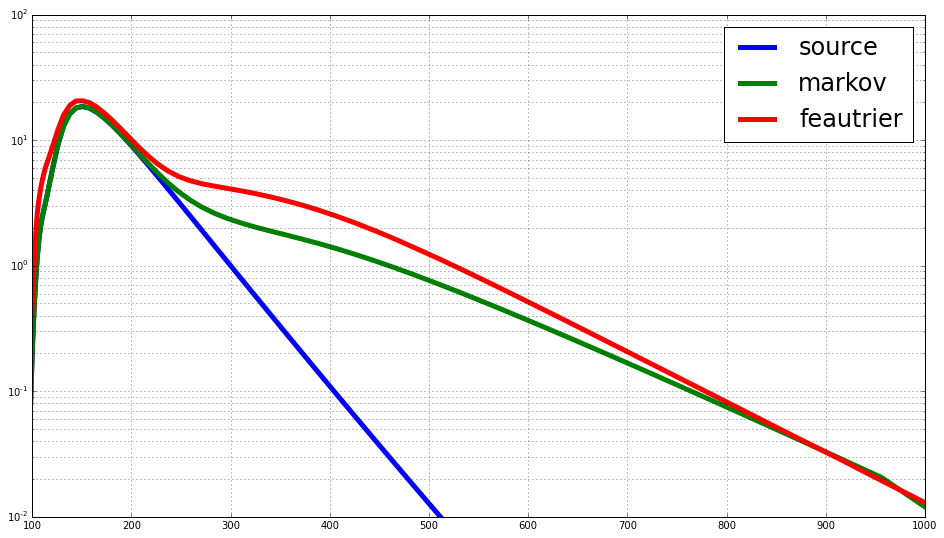

In [15]:
lw=5
plt.figure(figsize=(16,9))
plt.plot( z, sourcef['O+hv 834 A (initial)'], label="source", lw=lw )
plt.plot( atmosphere.z*1e-5, SF, label="markov", lw=lw  )
# plt.plot( z, pdf, label='pdf' )
plt.plot( feautrier["ALT"], feautrier["834 A (final)"], label="feautrier", lw=lw  )
plt.yscale('log')
# plt.xscale('log')
plt.xlim(100,1000)
plt.ylim(1e-2, 1e2)
plt.grid(b=True, which="both")
plt.legend(fontsize=24, framealpha=1.0);

(8000000.0, 100000000.0)

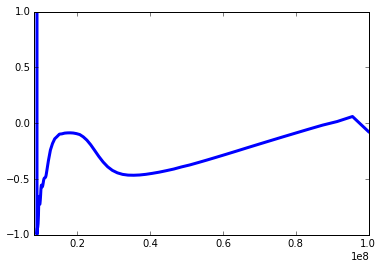

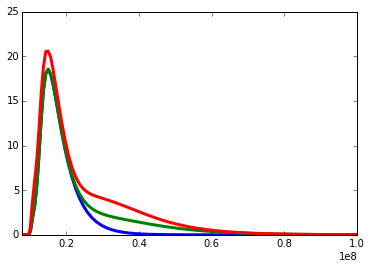

In [16]:
f_interp = scipy.interpolate.griddata( feautrier["ALT"]*1e5, feautrier["834 A (final)"], atmosphere.z )
plt.plot(atmosphere.z, SF/feautrier["834 A (final)"]-1)
plt.xlim(0.8e7,1e8)
plt.ylim(-1,1)
plt.figure()
plt.plot(atmosphere.z,S0[:len(SF)]*2)
plt.plot(atmosphere.z,SF)
plt.plot(atmosphere.z,f_interp)
plt.xlim(0.8e7,1e8)

## Next Steps

* Weight elements non-uniformly in optical depth
    * At higher altitudes, the initial source does change rapidly
    * Increasing altitude reolution to 1 km has no effect
* Add higher angular resolution
    * Not sure how this would help -- maybe having slightly shorter paths will increase transport
* Closer look at CFR -- I'll try this first

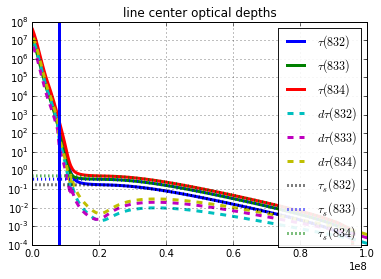

In [17]:
lines = [ plt.plot(atmosphere.z, atmosphere.tau[i][:,0], label=r"$\tau("+str(832+i)+")$") for i in xrange(3) ]
lines.append( [ plt.plot(atmosphere.z, atmosphere.dtau[i][:,0], label=r"$d\tau("+str(832+i)+")$", ls='--')
               for i in xrange(3) ] )
lines.append([ plt.plot(atmosphere.z, (atmosphere.tau_s[i][:,0]), label=r"$\tau_s("+str(i+832)+")$", ls=':')
              for i in xrange(3) ])
plt.legend(loc ='upper right')
plt.grid()
plt.title('line center optical depths')

plt.yscale('log')
plt.axvline(80e5)

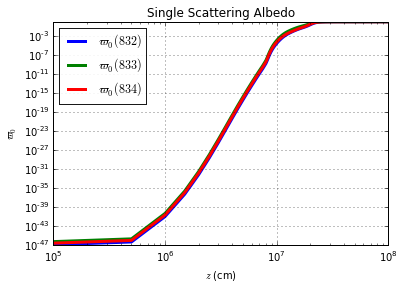

In [18]:
lines = ([ plt.plot(atmosphere.z, (atmosphere.albedo[i][:,0]),
                    label=r"$\varpi_0("+str(i+832)+")$") for i in xrange(3) ])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend(loc='best')
plt.title("Single Scattering Albedo")
plt.xlabel(r"$z$ (cm)")
plt.ylabel(r"$\varpi_0$")

In [19]:
w=2
Q = np.fromiter( (np.sum(atmosphere.lineshape[w] * atmosphere.Q(k,l,w)) 
                  for k in atmosphere.transient for l in atmosphere.transient  ), 
                dtype=float ) 
n = len(atmosphere.transient)
Q = Q.reshape((n,n))


R = np.fromiter( (atmosphere.R( l, e, w ) 
                  for l in atmosphere.transient for e in atmosphere.ergodic  ),
                dtype=float )
r = len(atmosphere.ergodic)
R = R.reshape( ( n, r ) )

AttributeError: 'Atmosphere' object has no attribute 'view_depth'

In [ ]:
I = np.eye( Q.shape[0] )
np.isclose(np.dot( Mm, (I-Q) ), I ).all()

In [ ]:
plt.figure()
plt.title("Q")
plt.imshow(Q, cmap=cm.cubehelix_r, norm=LogNorm(vmin=1e-10, vmax=1))
plt.colorbar();
plt.figure()
plt.title("R")
plt.imshow(R, cmap=cm.cubehelix_r)
plt.colorbar();

In [ ]:
n = np.array( [ s[1] for s in atmosphere.transient ] )
i = np.array( [ s[0] for s in atmosphere.transient ] )
plt.imshow(np.fromiter((z_target - z_source for z_source in atmosphere.z[n]\
 for z_target in atmosphere.z[n]), dtype=np.float ).reshape((len(n),len(n))), cmap=cm.RdBu_r)
plt.colorbar()

In [ ]:
x = atmosphere.z*1e-5
plt.plot( x, atmosphere.tau[0] )
plt.plot( x, atmosphere.dtau[0] )
plt.plot( x, atmosphere.albedo[0] )
plt.plot( x, atmosphere.oplus )
plt.plot( z, S(z*1e5) )
plt.axvline(90, color='k', ls='--')
plt.grid()
plt.ylim(1e-8,1e7)
plt.yscale('log')

In [ ]:
# plt.plot(atmosphere.z, msis_n["O"], label="O", ls='--', lw=2)
# plt.plot(atmosphere.z, msis_n["N2"], label="N2", ls='--', lw=2)
# plt.plot(atmosphere.z, msis_n["O2"], label="O2", ls='--', lw=2)
# plt.plot(atmosphere.z, atmosphere.oplus, label="O+", lw=2)
# edp = auric.retrieve("ionos.dat", features=['[e-]'])
# plt.plot(edp["ALT"]*1e5,edp["[e-]"], label="e-", alpha=0.5, lw=2)
# plt.plot()
# plt.legend(); plt.grid(b=True, which='both')
# plt.ylim(1e3,1e6)
# plt.yscale('log')

# Do the viewing angles work?

One way to find out. (The weights are incorrect, so it will probably explode or something.)

In [ ]:
X = atmosphere.multiple_scatter_matrix( 2 )

In [ ]:
print X.shape

pdf_interp = scipy.interpolate.interp1d( x=z[::-1]*1e5, y=pdf[::-1], bounds_error=False, fill_value=0 )

PI_0 = np.hstack( [pdf_interp(atmosphere.z) / 2]*2 ) 

out = np.dot( PI_0, X )
plt.plot( viewing_angles * 180 / np.pi, out )
plt.yscale('log')

In [ ]:
!say done
!espeak done

In [ ]:
plt.plot(z, pdf)
plt.plot(atmosphere.z*1e-5, PI_0[:atmosphere.N_layers])
plt.plot(atmosphere.z*1e-5, PI_0[atmosphere.N_layers:])
plt.yscale('log')

In [ ]:
mu_j = atmosphere.mu[0]
mu_e = -np.cos(viewing_angles[0])
tau = 1.0001
tau_prime = atmosphere.tau[2]
albedo = atmosphere.albedo[2]


# Sanity Check

The sum of each row of Q should be no more than one, since every photon comes from somewhere, but it may be less, because the absorbed photons are not accounted for by any state

In [ ]:
plt.plot(np.sum(Q ,axis=0))#+np.sum(R,axis=1) )
plt.yscale('log')
plt.ylim(1e-4,100)

In [ ]:
print np.arange(10).reshape((2,5))
print np.fromiter( (a*b for b in (+1, -1) for a in xrange(5) ), dtype=np.int32).reshape((2,5))

In [ ]:
kB = 1.3806488e-23 # J / K

# speed of light
c = 2.99792458e8 # m / s

def sdu( m, T ):
    """Doppler unit for mass `m` and temperature `T`.
    The standard deviation for a doppler-broadened line centered at 'nu' is `sdu( m, T ) * nu` """
    return np.sqrt( kB * T / m / c**2 )


In [ ]:
sdu( 16 * amu, 700 )

In [ ]:
a = np.arange(9).reshape(1,9)


In [ ]:
atmosphere.Q((0,5),(0,5),1).shape

In [ ]:
scipy.special.erf(1e-6)

In [ ]:
scipy.special.erf( mcrt.freq_param() )

In [ ]:
atmosphere.lineshape[0][5,:]

In [ ]:
Hbig=60
Nbig=1.5e5
hbig=330
def big_chapman(z):
    return (Nbig)*np.exp((1-(z-hbig)/Hbig-np.exp(-(z-hbig)/Hbig))/2)
Hlit=55
Nlit=7e3
hlit=120
def little_chapman(z): 
    return (Nlit)*np.exp((1-(z-hlit)/Hlit-np.exp(-(z-hlit)/Hlit))/2)
opd = big_chapman(msis_n['ALT']) + little_chapman(msis_n['ALT'])
plt.plot( msis_n['ALT'], opd )

In [ ]:
plt.plot(altitudes);plt.yscale('log');plt.grid(which='both')

In [ ]:
np.where(altitudes>=80), altitudes[:84]

In [ ]:
print len([ i for i in atmosphere.tau[0].T ])

In [ ]:
atmosphere.tau[1][-1,:].shape

In [ ]:
atmosphere.R( (0,10), 1, 1 )

In [ ]:
for i in mcrt.quad_gen_T( 1, 1, atmosphere.tau[2][10,:], atmosphere.tau[2][0:10,:],\
                         atmosphere.albedo[2][0:10,:], atmosphere.dtau[2][10,:] ):
    print i

atmosphere.tau[2].shape

In [ ]:
np.cos(atmosphere.viewing_angles)

In [ ]:
np.cos(viewing_angles)

In [ ]:
Q[:,90], Q[90,:]

In [ ]:
plt.colorbar?

In [37]:
plt.subplot?

In [24]:
a = np.arange(16).reshape(4,4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [25]:
a.mean(axis=0).reshape(2,2)

array([[ 6.,  7.],
       [ 8.,  9.]])

In [26]:
def sum_down_square(a):
    N = a.size
    n = int(np.sqrt(N))
    out = np.empty((n,n))
    for j in xrange(a.size):
        ra, ca = j//N, j%N
        ro, co = ra//n, ca//n
        out[ro,co] += a[ra,ca]
    return out
sum_down_square(a)

IndexError: index 4 is out of bounds for axis 1 with size 4